# F4BP01A / TP / Séparation aveugle de sources

Octobre 2016  
[antoine.houssais@telecom-bretagne.eu](mailto:antoine.houssais@telecom-bretagne.eu), [maxime.mouchet@telecom-bretagne.eu](mailto:maxime.mouchet@telecom-bretagne.eu)

*Convention de nommage : [s]calaire, [v]ecteur, [m]atrice*   
*Julia v0.5*

- [1. Introduction](#Introduction)  
- [2. Analyse en composantes indépendantes](#Analyse-en-composantes-indépendantes)  
  - [2.1 Notations](#Notations)  
  - [2.2 Première illustration](#Première-illustration)  
  - [2.3 Principe](#Principe)  
  - [2.4 Traitements préalables](#Traitement-préalables)
  - [2.5 Recherche d'une seule composante indépendante](#Recherche-d'une-seule-composante-indépendante)  
  - [2.6 Recherche de toutes les composantes indépendantes](#Recherche-de-toutes-les-composantes-indépendantes)  
- [3. Algorithme de séparation de sources basé sur les statistiques du second ordre](#Algorithme-de-séparation-de-sources-basé-sur-les-statistiques-du-second-ordre)
  - [3.1 Version simplifiée de l'algorithme SOBI](#Version-simplifiée-de-l'algorithme-SOBI)
- [4. Résulats](#Résultats)
- [A. Implémentation en C](#Implémentation-en-C)

In [1]:
using Distributions
using PyPlot
using MAT
using WAV

In [2]:
# Plot helpers to cleanup code
plt[:style][:use]("ggplot");
function plot_signal(y, ttl); figure(figsize=(10,1)); title(ttl); plot(y); end;
function plot_xy(x, y, xlbl, ylbl); xlabel(xlbl); ylabel(ylbl); plot(x, y, "."); end;

In [3]:
# Recorded signals used as an input to all algorithms
vars = matread("SignauxMelange.mat");
v_in_1 = vars["v_melange_out_1"]; v_in_2 = vars["v_melange_out_2"];
# Reference signals
vars = matread("SignauxReference.mat");
v_ref_1 = vars["v_melange_in_1"]; v_ref_2 = vars["v_melange_in_2"];

## Introduction

**Question 1 :**  
Soit deux vecteurs aléatoires $\boldsymbol{X}$ et $\boldsymbol{Y}$, on définit la matrice de covariance par la relation suivante :

$$
\mathrm{cov}(\boldsymbol{X}, \boldsymbol{Y}) = \mathbb{E}\{\boldsymbol{X}\boldsymbol{Y}^T\} - \mathbb{E}\{\boldsymbol{X}\}\mathbb{E}\{\boldsymbol{Y}\}^T
$$

Si $\mathrm{cov}(\boldsymbol{X}, \boldsymbol{Y}) = \mathbb{I}_n$ alors $\boldsymbol{X}$ et $\boldsymbol{Y}$ ne sont pas corrélés.

On dit que $\boldsymbol{X}$ est indépendant de  $\boldsymbol{Y}$ (et *vice versa*) si l'information ou l'absence d'information sur $\boldsymbol{Y}$ n'apporte aucune information sur  $\boldsymbol{X}$. Dans ce cas les variables ne sont pas corrélés et $\mathrm{cov}(\boldsymbol{X}, \boldsymbol{Y}) = \mathbb{I}_n$.  
La réciproque est cependant fausse la plupart du temps, la non-corrélation n'implique pas l'indépendance.

## Analyse en composantes indépendantes

### Notations
On considère $n$ signaux $x_1,x_2,...,x_n$ correspondant à des mélanges de $n$ composantes indépendantes :

$$x_j = a_{j1}s_1 + a_{j2}s_2 + a_{jn}s_n,\quad 1 \leq j \leq n$$

On note les vecteurs suivants :

$$
\boldsymbol{x} = 
\begin{pmatrix}
    x_1\\
    x_2\\
    \vdots\\
    x_n
  \end{pmatrix}\quad
\boldsymbol{s} =
\begin{pmatrix}
    s_1\\
    s_2\\
    \vdots\\
    s_n
  \end{pmatrix}\quad
\boldsymbol{A} =
\begin{pmatrix}
    a_{11} & \dots & \dots & a_{1n}\\
    a_{21} & \ddots & & a_{2n}\\
    \vdots & & \ddots & \vdots \\
    a_{n1} & \dots & \dots & a_{nn}
  \end{pmatrix}
$$

On peut donc réécrire le problème sous forme matricielle :

$$\boldsymbol{x} = \boldsymbol{A}\boldsymbol{s}$$

$A$ est appelée matrice de mélange. Nous allons chercher à estimer $\boldsymbol{A}$ puis $\boldsymbol{s}$ à partir de la connaissance de $\boldsymbol{x}$.


**Question 2 :**  
On estime une matrice $\boldsymbol{W}$ telle que $\boldsymbol{W}\boldsymbol{A} = \boldsymbol{I}_n$. Dans notre cas $\boldsymbol{A}$ est une matrice carré ($n$ signaux formés de $n$ composantes), et on suppose son déterminant non nul, on peut donc écrire $\boldsymbol{W} = \boldsymbol{A}^{-1}$. Ainsi :

\begin{equation}
\begin{split}
\boldsymbol{W}\boldsymbol{x} & = \boldsymbol{W}\boldsymbol{A}\boldsymbol{s} \\
& = \boldsymbol{A}^{-1}\boldsymbol{A}\boldsymbol{s} \\
& = \boldsymbol{s}
\end{split}
\end{equation}

On voit donc qu'une fois la matrice $\boldsymbol{W}$ estimé il est possible de retrouver les signaux sources par un simple produit matriciel.

**Question 3 :**  
On généralise le problème à un nombre $m$ de signaux observés formés de $n$ composantes indépendantes.  
Si $m \geq n$, on peut tronquer le nombre de signaux observés à $n$ pour avoir $\boldsymbol{A}$ carré et donc inversible.  
Si $m \lt n$, la matrice de mélange $\boldsymbol{A}$ ne sera pas carré (nous avons moins d'équations que d'inconnues), et on ne pourra pas l'inverser pour obtenir l'équation de la question 2. On ne pourra pas retrouver tous les signaux sources.

### Première illustration

On considère deux signaux aléatoires indépendants $s_1, s_2 \sim \mathcal{U}_{[-\sqrt{3},\sqrt{3}]}$

$$
f_{s_i}(x)=
\begin{cases}
\frac{1}{2\sqrt{3}} & \text{si } |x| \leq \sqrt{3}\\
0 & \text{sinon}
\end{cases},\quad
i = 1,2
$$

**Question 4 :**  
Vérifions que $s_1$ et $s_2$ soient de variance unité :

\begin{equation}
\begin{split}
\mathrm{var}\{s_i\}
& = \mathbb{E}\{s_i^2\} - \mathbb{E}\{s_i\}^2 \\
& = \int x^2 \frac{1}{2\sqrt{3}} dx - \int x \frac{1}{2\sqrt{3}} dx \\
& = \left[\frac{x^3}{3}\frac{1}{2\sqrt{3}}\right]_{-\sqrt{3}}^{\sqrt{3}} - \left[\frac{x^2}{2}\frac{1}{2\sqrt{3}}\right]_{-\sqrt{3}}^{\sqrt{3}} \\
& = 1 - 0^2 \\
& = 1
\end{split}
\end{equation}

**Question 5 :**  
$s_1$ et $s_2$ sont indépendants, donc :

$$
f_{s_1,s_2}(x,y) = \mathbb{P}\{s_1=x \cap s_2=y\} = \mathbb{P}\{s_1=x\}\mathbb{P}\{s_2=y\}
$$

On en déduit :

\begin{equation}
\begin{split}
f_{s_1,s_2}(x,y)
& = \begin{cases}
\frac{1}{12}\, & \text{si } |x| \leq \sqrt{3}, |y| \leq \sqrt{3}\\
0 & \text{sinon}
\end{cases}
\end{split}
\end{equation}

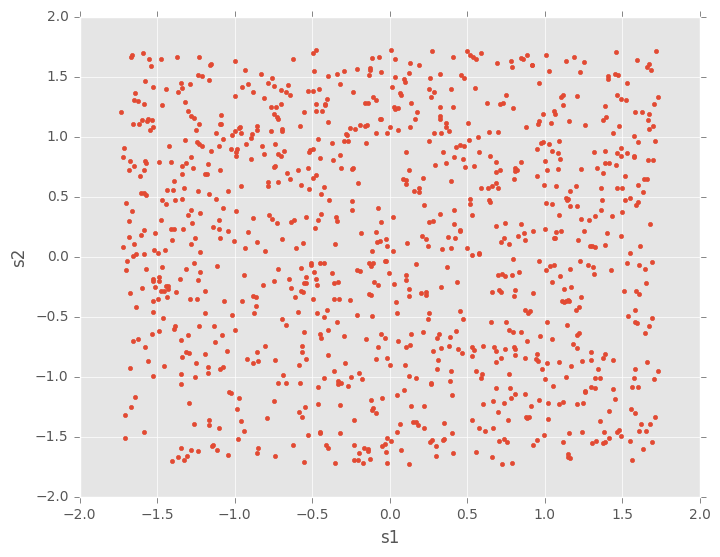

In [4]:
v_s1 = rand(Uniform(-sqrt(3), sqrt(3)), 1000);
v_s2 = rand(Uniform(-sqrt(3), sqrt(3)), 1000);
plot_xy(v_s1, v_s2, "s1", "s2");

L'indépendance des deux variables se traduit par l'absence de tendance dans le nuage de point. En effet on voit que les valeurs prises par $s_2$ sont uniformément distribuées quelque soit la valeur de $s_1$.

**Question 6 :**  
Soit la matrice de mélange :

$$
\boldsymbol{A} =
\begin{pmatrix}
1 & 1 \\ -1 & 2
\end{pmatrix}
$$

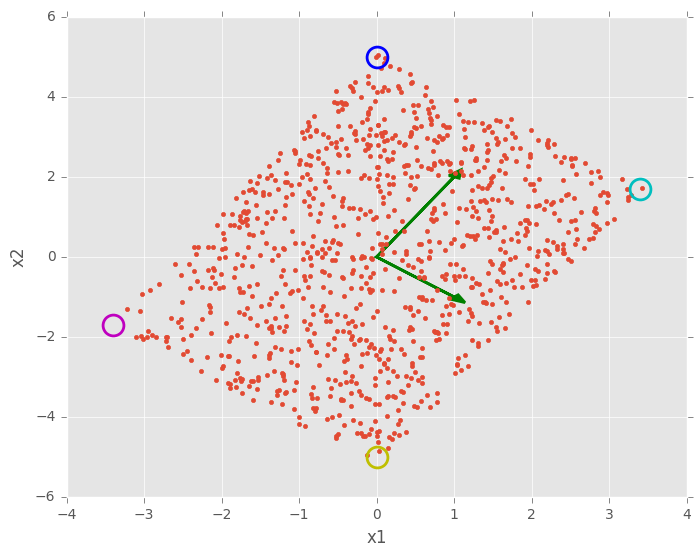

In [5]:
m_a = [1 1; -1 2];
m_x = m_a*[v_s1 v_s2]';

plot_xy(m_x[1,:], m_x[2,:], "x1", "x2");
plot(0, 5, "o", ms=15, mec="b", mfc="none", mew=2);
plot(0, -5, "o", ms=15, mec="y", mfc="none", mew=2);
plot(3.4, 1.7, "o", ms=15, mec="c", mfc="none", mew=2);
plot(-3.4, -1.7, "o", ms=15, mec="m", mfc="none", mew=2);
arrow(0, 0, 1, -1, linewidth=2.0, head_width=0.15, head_length=0.2, fc="g", ec="g");
arrow(0, 0, 1, 2, linewidth=2.0, head_width=0.15, head_length=0.2, fc="g", ec="g");

On constate une tendance (corrélation positive) dans le nuage de point. En effet, et contrairement au graphique précédent les valeurs de $x_2$ ne sont pas distribuées identiquement quelque soit la la valeur de $x_1$. Une corrélation non nulle implique la non-indépendance des variables.

**Question 7:**  
On constate sur le graphique précédent que les bords du parallélogramme ont la même direction que les vecteurs définis par les colonnes de la matrice $\boldsymbol{A}$ (flèches vertes). Nous pouvons donc retrouver ces vecteurs à partir des coordonnées des coins de la figure :

$$
\hat{\boldsymbol{A}} =
\begin{bmatrix}
   (\color{cyan}{3.2}-\color{blue}{0}) & (\color{blue}{0}-(\color{magenta}{-3.2})) \\
   (\color{cyan}{2}-\color{blue}{5}) & (\color{blue}{5}-(\color{magenta}{-2}))
\end{bmatrix}  =
\begin{bmatrix}
   3.2 & 3.2 \\
   -3 & 7
\end{bmatrix}
$$

On retrouve la matrice $\boldsymbol{A}$ à un coefficient d'échelle près. Cependant cette technique ne fonctionne que pour des variables suivant une loi uniforme, car leur densité de probabilité conjointe forme un parallélogramme.

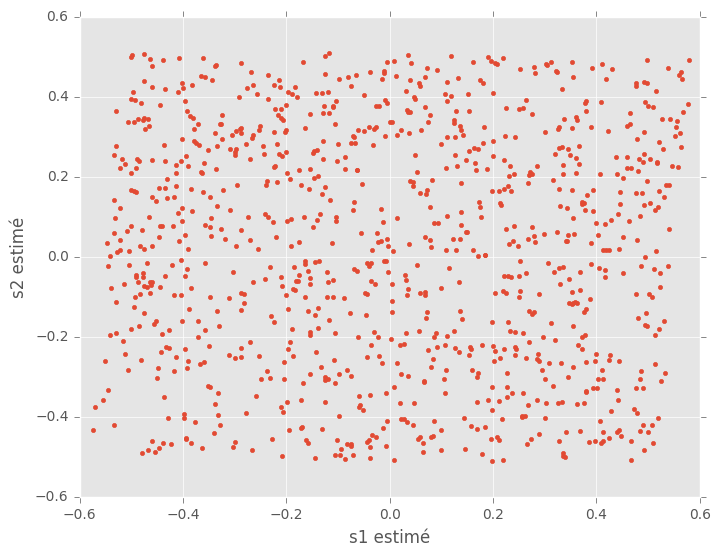

In [6]:
m_a_est = [3.2 3.2; -3 7]
m_w = inv(m_a_est);
m_s_est = m_w*m_x;
plot_xy(m_s_est[1,:], m_s_est[2,:], "s1 estimé", "s2 estimé");

**Question 8 :**  
On considère désormais une densité de probabilité gaussienne de moyenne nulle et de variance unité pour $s_1$ et $s_2$ :

$$
f_{s_i}(x)= \frac{1}{\sqrt{2\pi}}\mathrm{exp}\left({-\frac{x^2}{2}}\right),\quad i = 1,2
$$

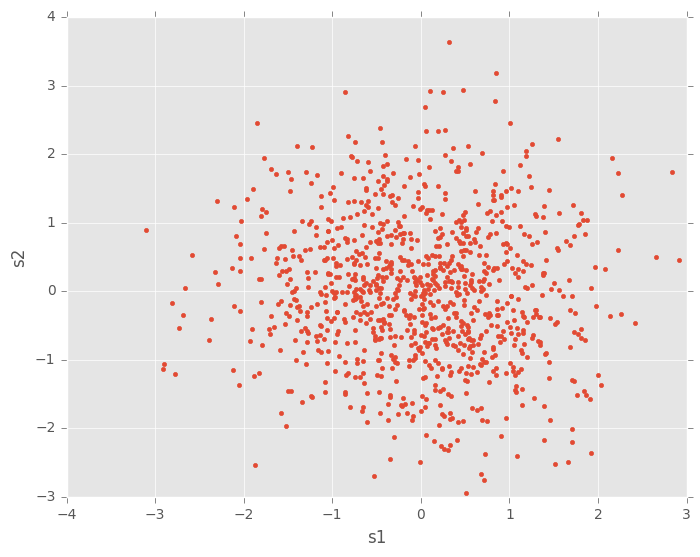

In [7]:
v_s1 = rand(Normal(0, 1), 1000);
v_s2 = rand(Normal(0, 1), 1000);
plot_xy(v_s1, v_s2, "s1", "s2");

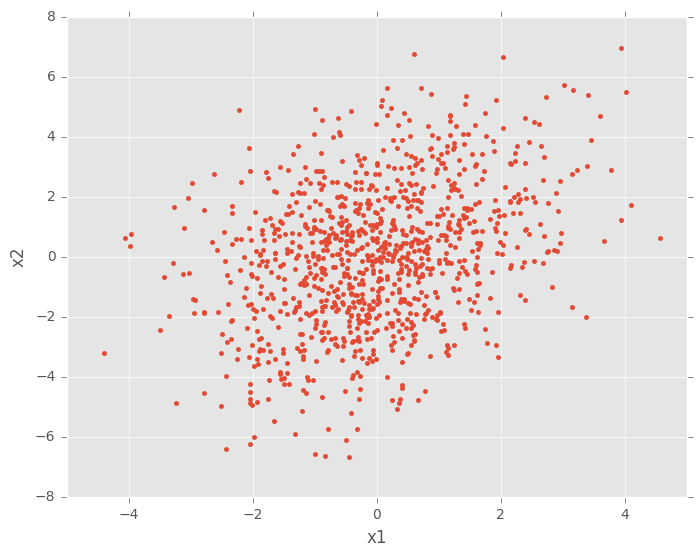

In [8]:
m_x = m_a*[v_s1 v_s2]';
plot_xy(m_x[1,:], m_x[2,:], "x1", "x2");

On visualise également la corrélation positive entre les deux variables dans le cas gaussien.  
Comme la densité de probabilité jointe forme une ellipse, on pourrait estimer les coefficients de $\boldsymbol{A}$ en mesurant les vecteurs parallèles au grand axe et au petit axe. Cependant l'erreur serait plus grande que dans le cas précédent, et pour une matrice  $\boldsymbol{A}$ orthogonale il serait complètement impossible de retrouver les coefficients car la densité jointe des lois gaussiennes formerait un cercle (impossible de visualiser une rotation dans ce cas).

### Principe

**Question 9 :**  
La densité de probabilité de la somme de variables aléatoires indépendantes est égale au produit de convolution des lois. Pour la somme de deux variables suivant une loi uniforme sur le même intervalle, on obtiendra donc une fonction triangle (produit de convolution de deux portes). Pour simplifier les calculs des sommes de plusieurs variables aléatoires nous allons utiliser la [loi de Irwin-Hall](https://en.wikipedia.org/wiki/Irwin–Hall_distribution).  
Pour une somme de $n$ variables aléatoires iid. de loi uniforme continue sur $[0,1]$, la loi de Irwin-Hall est définie par la densité de probabilité suivante :

\begin{equation}
\begin{split}
f_X(x;n) &=
\frac{1}{2\left(n-1\right)!}\sum_{k=0}^{n}\left(-1\right)^k{n \choose k}\left(x-k\right)^{n-1}\mathrm{sgn}(x-k) \\
\end{split}
\end{equation}

Il en suit :

\begin{equation}
\begin{split}
f_X(x;2) &=
\frac{1}{2} [x\,\mathrm{sgn}(x) - 2(x-1)\,\mathrm{sgn}(x-1) + (x-2)\,\mathrm{sgn}(x-2)] \\
f_X(x;3) &=
\frac{1}{4} [x^2\,\mathrm{sgn}(x) - 3(x-1)^2\,\mathrm{sgn}(x-1) + 3(x-2)^2\,\mathrm{sgn}(x-2) - (x-3)^2\,\mathrm{sgn}(x-3)] \\
f_X(x;4) &=
\frac{1}{12} [x^4\,\mathrm{sgn}(x) - 4(x-1)^3\,\mathrm{sgn}(x-1) + 6(x-2)^3\,\mathrm{sgn}(x-2) - 4(x-3)^3\,\mathrm{sgn}(x-3) + (x-4)^3\,\mathrm{sgn}(x-4)]
\end{split}
\end{equation}


Ses moments d'ordre 1 et 2 sont donnés par :

$$
\mathbb{E}\{X\} = \frac{n}{2} \quad \mathrm{Var}\{X\} = \frac{n}{12}
$$

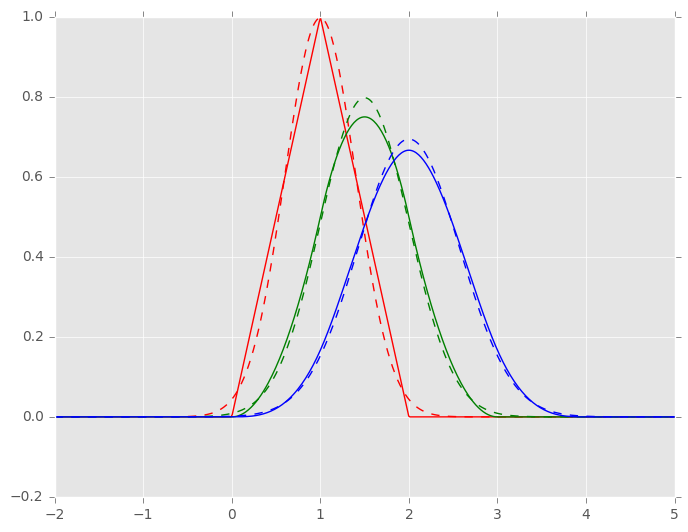

In [9]:
v_x = linspace(-2, 5, 500);

# Lois de Irwin-Hall pour n lois uniformes [0,1]
v_ih_2 = (1/2)  * ((v_x.*sign(v_x)) + (-2*(v_x-1).*sign(v_x-1)) + ((v_x-2).*sign(v_x-2)));
v_ih_3 = (1/4)  * (((v_x.^2).*sign(v_x)) + (-3*((v_x-1).^2).*sign(v_x-1)) + (3*((v_x-2).^2).*sign(v_x-2)) + (-1*((v_x-3).^2).*sign(v_x-3)));
v_ih_4 = (1/12) * (((v_x.^3).*sign(v_x)) + (-4*((v_x-1).^3).*sign(v_x-1)) + (6*((v_x-2).^3).*sign(v_x-2)) + (-4*((v_x-3).^3).*sign(v_x-3)) + (((v_x-4).^3).*sign(v_x-4)));

# Lois normales de moyenne et de variance correspondantes aux lois de Irwin-Hall
v_g_2 = (1/sqrt(2*pi*(0.16))) * exp((-1/2) * (((v_x-1).^2)/0.16))
v_g_3 = (1/sqrt(2*pi*(0.25))) * exp((-1/2) * (((v_x-1.5).^2)/0.25))
v_g_4 = (1/sqrt(2*pi*(0.33))) * exp((-1/2) * (((v_x-2).^2)/0.33))

plot(v_x, v_ih_2, "r-"); plot(v_x, v_g_2, "r--");
plot(v_x, v_ih_3, "g-"); plot(v_x, v_g_3, "g--");
plot(v_x, v_ih_4, "b-"); plot(v_x, v_g_4, "b--");

On vérifie le théorème central limite, c'est à dire, la somme de variables aléatoires tend vers une loi normale. Ici on constate bien que la densité d'une somme de variables uniformes (traits continus) tend vers une loi normale (pointillés) de même espérance et variance.

**Question 10 :**  
Les moments d'ordre paires et impaires de la loi normale sont donnés par la formule suivante (cf. [wiki](https://fr.wikipedia.org/wiki/Loi_normale#Moments)) :

$$
\begin{cases}
\mu_{2k} = \mathbb E[(X-\mu)^{2k}] = \frac{(2\, k) !}{2^k k!}\sigma^{2k}\\
\mu_{2k+1} = \mathbb E[(X-\mu)^{2k+1}] = 0 
\end{cases}
$$

On en déduit le kurtosis pour une variable aléatoire gausienne centrée :

\begin{equation}
\begin{split}
\mathrm{kurt}(y)
& = \mathbb{E}\{y^4\} - 3(\mathbb{E}\{y^2\})^2 \\
& = 3\sigma^4 - 3(\sigma^2)^2 \\
& = 0
\end{split}
\end{equation}

### Traitement préalables

**Question 11 :**  

E est orthogonale donc $E^T = E^{-1}$.  
De plus, $\mathbb{D}$ est diagonale donc $\mathbb{D} = \mathbb{D}^T$ et $\mathbb{D}$ contient les valeurs propres $\mathbb{E}\{xx^T\}$ donc aucune valeur de $\mathbb{D}$ n'est nulle.

\begin{equation}
\begin{split}
\mathbb{E}\{\tilde{x}\tilde{x}^T\} 
&= \mathbb{E}\{ED^{-1/2}Exx^TED^{-1/2}E\} \\
&= ED^{-1/2}E\,\mathbb{E}\{xx^T\}\, E(D^{-1/2})^TE^T \\
&=  ED^{-1/2}E^T\, EDE^T \, E(D^{-1/2})^TE^T \\
&= ED^{-1/2}D(D^{-1/2})^TE^T \\
&= E \,\mathbb{I}_n \, E^T \\
&= \mathbb{I}_n
\end{split}
\end{equation}

In [10]:
function whiten(M)
    # Normalized autocorrelation
    m_rx = (M*M') / size(M)[2]
    
    # Eigenvalues (m_d) and eigenvectors (m_e) matrices
    m_d = diagm(eig(m_rx)[1]);
    m_e = eig(m_rx)[2];
    
    # Whitening
    return m_e * (m_d^-0.5) * m_e' * M;
end;

In [11]:
m_x  = hcat(v_in_1, v_in_2)'; # 2×220500
m_xw = whiten(m_x);

println("E[XX'] = ", ((m_x*m_x') / size(m_x)[2]), "\nE[XwXw'] = ", ((m_xw*m_xw') / size(m_xw)[2]))

E[XX'] = [0.0353068 -0.0112548; -0.0112548 0.0463174]
E[XwXw'] = [1.0 -2.60629e-16; -2.60629e-16 1.0]


Numériquement on retrouve bien la matrice identité (à une erreur d'arrondi près).

### Recherche d'une seule composante indépendante

**Question 12 :**  
Soit la fonction d'approximation de la néguentropie :

$$
G(y) = \mathrm{ln}\,\mathrm{cosh}(y)
$$

On calcule sa dérivée première $g(y)$ et seconde $g'(y)$ :

\begin{equation}
\begin{split}
g(y) & = \frac{\mathrm{sinh}(y)}{\mathrm{cosh}(y)} & = \mathrm{tanh}(y) \\
g'(y) & = \frac{1}{\mathrm{cosh}^2(y)} & = \mathrm{sech}^2(y)
\end{split}
\end{equation}

**Question 13 :**

In [12]:
function ica_first(v_in_1, v_in_2, v_w=rand(2)', s_ech_factor=1, s_iterations=100)
    m_mix = hcat(v_in_1, v_in_2)';
    
    # Center mixes
    m_mix[1,:] -= mean(m_mix[1,:]);
    m_mix[2,:] -= mean(m_mix[2,:]);
    
    # Whitening
    m_xw = whiten(m_mix);
    
    # Search the first independent component
    v_w = v_w / norm(v_w);
    
    for i = 1:s_iterations
        # Estimate signal entropy
        v_y = tanh(v_w);
        v_z = sech(v_w).^2;
        v_w[1] = mean(v_y .* m_xw[1,:]) - (mean(v_z) * v_w[1]);
        v_w[2] = mean(v_y .* m_xw[2,:]) - (mean(v_z) * v_w[2]);
        v_w = v_w / norm(v_w)
    end
    
    return v_w;
end;

In [13]:
println(ica_first(v_in_1, v_in_2));
println(ica_first(v_in_1, v_in_2));
println(ica_first(v_in_1, v_in_2));

[0.715776 0.69833]
[0.589284 0.807926]
[0.35873 0.933441]


Le vecteur $\boldsymbol{w}$ est choisi aléatoirement, on voit que pour plusieurs exécutions de l'algorithme le résultat obtenu est différent. Ceci provient du fait que la fonction d'approximation de la néguentropie possède plusieurs maximas locaux correspondant aux composantes indépendantes. Ainsi suivant le point de départ on trouve l'une ou l'autre des composantes. De plus le nombre d'itérations étant fixé (100 dans notre cas), il est possible que nous nous arrêtions avant la localisation exacte du maximum.

### Recherche de toutes les composantes indépendantes

**Question 14 :**

In [14]:
function ica_full(v_in_1, v_in_2, v_w=rand(2)', s_ech_factor=1, s_iterations=100)
    m_mix = hcat(v_in_1, v_in_2)';
    
    # Center mixes
    m_mix[1,:] -= mean(m_mix[1,:]);
    m_mix[2,:] -= mean(m_mix[2,:]);
    
    # Whitening
    m_xw = whiten(m_mix);
    
    # Search the first independent component
    v_w = v_w / norm(v_w);
    v_y1 = v_w * m_xw;
    
    for i = 1:s_iterations
        # Estimate signal entropy
        v_y = tanh(v_y1);
        v_z = sech(v_y1).^2;
        v_w[1] = mean(v_y' .* m_xw[1,:]) - (mean(v_z) * v_w[1]);
        v_w[2] = mean(v_y' .* m_xw[2,:]) - (mean(v_z) * v_w[2]);
        v_w = v_w / norm(v_w)
        v_y1 = v_w * m_xw
    end
    
    # Search the second component
    v_z = [-v_w[2] v_w[1]];
    m_b = [v_w; v_z];

    # Estimate signals
    m_out = m_b * m_xw;
    
    # Scale and return
    return m_out * s_ech_factor;
end;

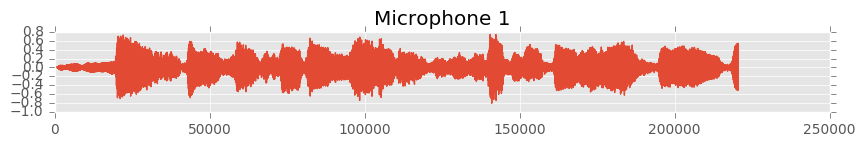

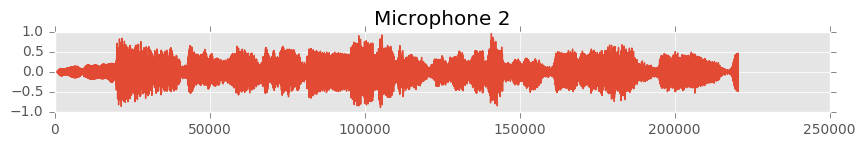

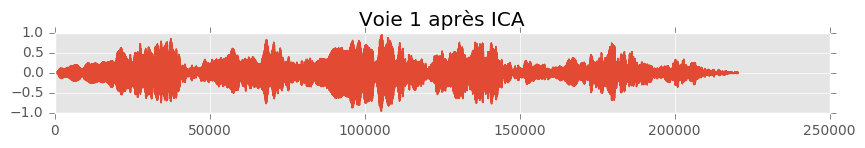

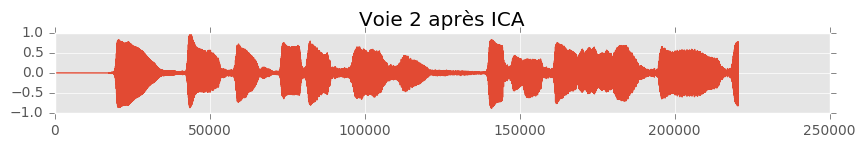

In [15]:
m_out = ica_full(v_in_1, v_in_2);
m_out[1,:] = m_out[1,:] ./ maximum(abs(m_out[1,:]))
m_out[2,:] = m_out[2,:] ./ maximum(abs(m_out[2,:]))

plot_signal(v_in_1, "Microphone 1");
plot_signal(v_in_2, "Microphone 2");
plot_signal(m_out[1,:], "Voie 1 après ICA");
plot_signal(m_out[2,:], "Voie 2 après ICA");

wavwrite(m_out[1,:], "out_ica_1.wav", Fs=44100);
wavwrite(m_out[2,:], "out_ica_2.wav", Fs=44100);

## Algorithme de séparation de sources basé sur les statistiques du second ordre

### Version simplifiée de l'algorithme SOBI

In [16]:
off(M) = (1/(size(M,1)*(size(M,1)-1))) * (sum(M) - trace(M));
tr(M) = (1/size(M,1)) * trace(M);

In [17]:
function sobi(v_in_1, v_in_2, sigma2=0)
    # Mixing matrix output
    m_mix = hcat(v_in_1, v_in_2)';
    
    # Center mixes
    m_mix[1,:] -= mean(m_mix[1,:]);
    m_mix[2,:] -= mean(m_mix[2,:]);
    
    # Normalization
    m_xw = m_mix .* sqrt(2 / (var(m_mix[1,:]) + var(m_mix[2,:])))
    
    # Estimate covariance
    s_n = 4;
    s_t = length(m_xw[1,:]);
    s_l = Int64(s_t/s_n);

    ## 1. Reshape 1xT to N*(T/N)
    m_x1 = reshape(m_xw[1,:], (s_n, s_l));
    m_x2 = reshape(m_xw[2,:], (s_n, s_l));
    
    ## 2. Product
    m_r11 = (1/s_l) * (m_x1*m_x1');
    m_r12 = (1/s_l) * (m_x1*m_x2');
    m_r22 = (1/s_l) * (m_x2*m_x2');
    
    # Compute coefficients
    s_f1  = off(m_r11);
    s_f2  = off(m_r22);
    s_f12 = off(m_r12);
    s_t1  = tr(m_r11);
    s_t2  = tr(m_r22);
    s_t12 = tr(m_r12);
    
    alpha  = (2*s_f12*s_t12) - (s_f1 * (s_t2 - sigma2) + s_f2 * (s_t1 - sigma2));
    beta   = 2*((s_t12^2) - (s_t1 - sigma2) * (s_t2 - sigma2));
    gamma2 = (s_f1*(s_t2 - sigma2) - s_f2*(s_t1 - sigma2))^2 +
             4 * (s_f12*(s_t2 - sigma2) - s_t12*s_f2) * (s_f12*(s_t1 - sigma2) - s_t12*s_f1);

    s_d1 = alpha - sqrt(gamma2);
    s_d2 = alpha + sqrt(gamma2);
    
    # Generate matrix
    s_a11 = beta * s_f1 - (s_t1 - sigma2) * s_d1;
    s_a22 = beta * s_f2 - (s_t2 - sigma2) * s_d2;
    s_a12 = beta * s_f12 - s_t12 * s_d2;
    s_a21 = beta * s_f12 - s_t12 * s_d1;
    m_a_est = [s_a11 s_a12; s_a21 s_a22];
    # println("m_a_est: ", m_a_est, "\ninv(m_a_est): ", inv(m_a_est));
    
    return (m_xw' * inv(m_a_est))';
end;

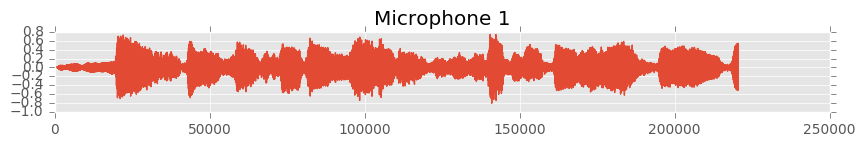

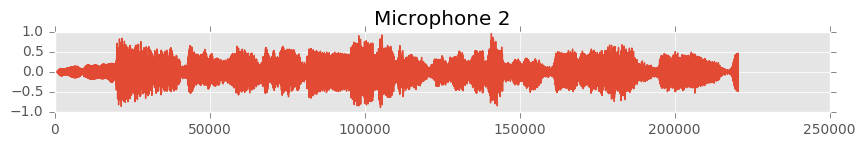

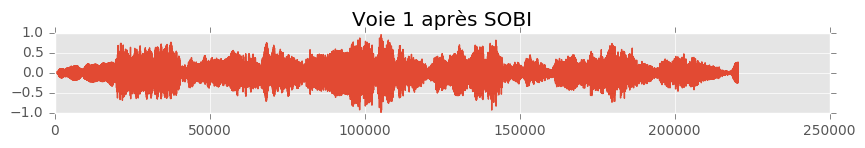

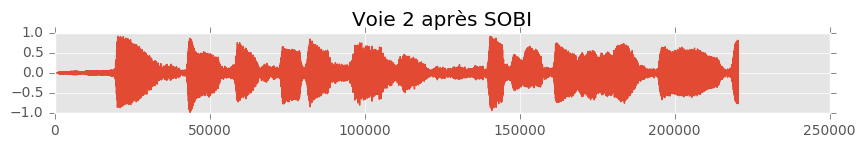

In [18]:
m_out = sobi(v_in_1, v_in_2);
m_out[1,:] = m_out[1,:] ./ maximum(abs(m_out[1,:]))
m_out[2,:] = m_out[2,:] ./ maximum(abs(m_out[2,:]))

plot_signal(v_in_1, "Microphone 1");
plot_signal(v_in_2, "Microphone 2");
plot_signal(m_out[1,:], "Voie 1 après SOBI");
plot_signal(m_out[2,:], "Voie 2 après SOBI");

wavwrite(m_out[1,:], "out_sobi_1.wav", Fs=44100);
wavwrite(m_out[2,:], "out_sobi_2.wav", Fs=44100);

## Résultats

In [19]:
function eqmn_db(v_estimated, v_reference)
    return 10*log10(1 - ((v_reference'*v_estimated)[1] / (norm(v_reference) * norm(v_estimated)))^2);
end;

### Synthèse des sorties

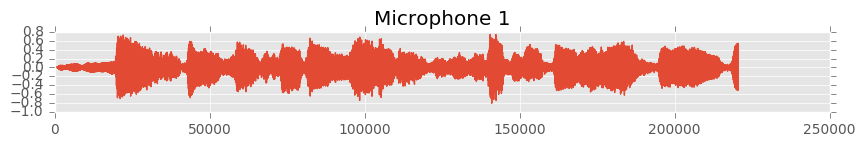

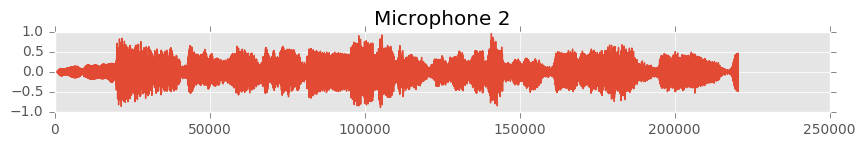

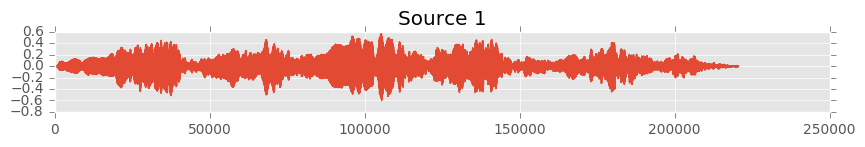

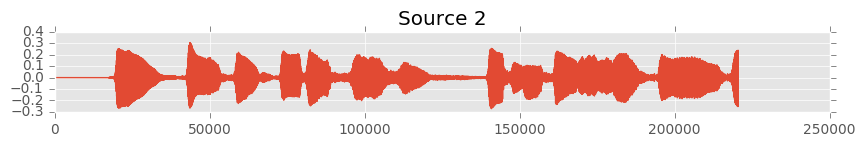

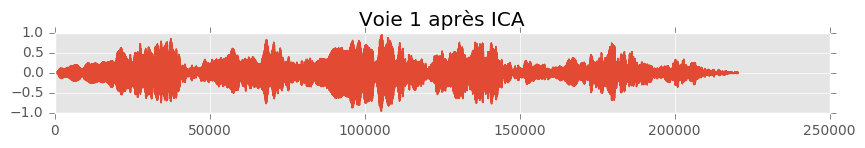

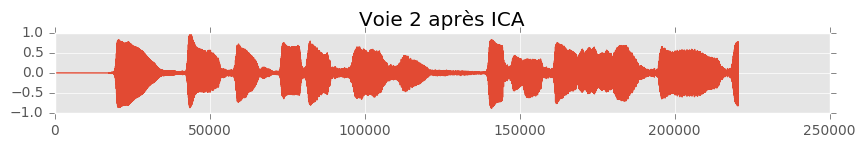

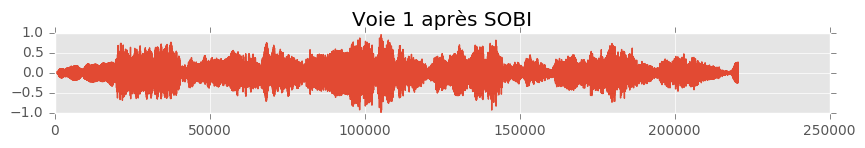

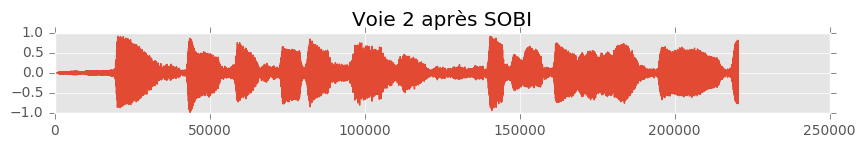

In [20]:
m_out_ica  = ica_full(v_in_1, v_in_2);
m_out_sobi = sobi(v_in_1, v_in_2);

# Scale between 0 and 1
for i = 1:2
    m_out_ica[i,:]  = m_out_ica[i,:]  ./ maximum(abs(m_out_ica[i,:]))
    m_out_sobi[i,:] = m_out_sobi[i,:] ./ maximum(abs(m_out_sobi[i,:]))
end

plot_signal(v_in_1, "Microphone 1");
plot_signal(v_in_2, "Microphone 2");
plot_signal(v_ref_1, "Source 1");
plot_signal(v_ref_2, "Source 2");
plot_signal(m_out_ica[1,:], "Voie 1 après ICA");
plot_signal(m_out_ica[2,:], "Voie 2 après ICA");
plot_signal(m_out_sobi[1,:], "Voie 1 après SOBI");
plot_signal(m_out_sobi[2,:], "Voie 2 après SOBI");

### Comparaison

In [21]:
# Compute ICA estimation errors
s_ica_eqmn_db_1 = eqmn_db(m_out_ica[1,:], v_ref_1)
s_ica_eqmn_db_2 = eqmn_db(m_out_ica[2,:], v_ref_2)

# Compute SOBI estimation errors
s_sobi_eqmn_db_1 = eqmn_db(m_out_sobi[1,:], v_ref_1)
s_sobi_eqmn_db_2 = eqmn_db(m_out_sobi[2,:], v_ref_2)

println("+ ICA")
println("EQMN (signal 1): ", s_ica_eqmn_db_1, " dB")
println("EQMN (signal 2): ", s_ica_eqmn_db_2, " dB")

println("\n+ SOBI")
println("EQMN (signal 1): ", s_sobi_eqmn_db_1, " dB")
println("EQMN (signal 2): ", s_sobi_eqmn_db_2, " dB")

+ ICA
EQMN (signal 1): -57.15570439314689 dB
EQMN (signal 2): -57.15570439314689 dB

+ SOBI
EQMN (signal 1): -8.312444937257968 dB
EQMN (signal 2): -14.758622699154802 dB


Les sorties peuvent être écoutées dans les fichiers suivants :
```
out_ica_1.wav, out_ica_2.wav, out_sobi_1.wav, out_sobi_2.wav
```

L'algorithme ICA sépare complètement les deux voies, l'erreur est très faible (-57 dB).  
Cela se vérifie à l'écoute où nous pouvons entendre qu'une seule voie par sortie.  

L'algorithme SOBI simplifié proposé est moins performant pour la séparation des voies.  
L'erreur est plus importante (-8 dB sur la première voie, -14 dB sur la seconde), et à l'écoute nous pouvons entendre l'autre voie en fond.  
L'estimation de la matrice covariance pour un nombre de décalages temporel plus important permet d'améliorer la performance de l'algorithme, en échange d'une utilisation mémoire supplémentaire.

L'algorithme SOBI est cependant intéressant pour une application en temps réel, car il est déterministe. Il ne repose pas sur le choix d'un vecteur aléatoire et la convergence vers un maximum local, mais uniquement sur le calcul de produits matriciels.

## Implémentation en C

Une implémentation en C de l'algorithme SOBI est fournie dans le dossier `C/`. Elle peut-être éxécuté avec les commandes suivantes :  

```
make
bin/sobi
```

En plus de la structure de base fournie, l'implémentation est séparé dans deux fichiers :
- *linalg.c :* structures vecteur/matrice, et fonctions d'algèbre linéaire pour simplifier le code de l'algorithme.
- *separation.c :* logique principale de l'algorithme.

Nous obtenons une erreur identique à la version Julia pour le signal 1, cependant l'erreur pour le signal 2 est plus faible (-66 dB).
La logique des deux implémentations étant identique, on peut supposer que des erreurs d'arrondi sur les nombres flottants avec Julia limitent la performance de l'algorithme en termes de séparation des voies.
Nous pourrions étudier plus en détail les types inférés par Julia et comparer leur précision avec les types utilisés en C (*flottant 64 bit*).
